In [9]:
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime
import time  # Simulate a process with sleep
import matplotlib 
from cycler import cycler

import numpy as np
from sklearn.linear_model import LinearRegression

matplotlib.rcParams['figure.figsize'] = (12,5)
matplotlib.rcParams['figure.dpi'] = 250

matplotlib.rcParams['axes.grid'] = True  # Enable grid by default
matplotlib.rcParams['grid.color'] = 'black'  # Set grid color
matplotlib.rcParams['grid.alpha'] = 0.7    # Set grid transparency
matplotlib.rcParams['grid.linestyle'] = (0, (6, 4))
matplotlib.rcParams['grid.linewidth'] = 0.5  # Thin grid lines

matplotlib.rcParams['xtick.minor.visible'] = True  # Show minor ticks on x-axis
matplotlib.rcParams['ytick.minor.visible'] = True  # Show minor ticks on y-axis

matplotlib.rcParams['xtick.direction'] = 'in'  # Tick direction (inwards)
matplotlib.rcParams['ytick.direction'] = 'in'

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#0000FF', 'r', 'g', 'darkorange', 'k', 'y'])
matplotlib.rcParams['lines.linewidth'] = 1.3  # Standard line width

matplotlib.rcParams['font.size'] = 12  # Default font size
# matplotlib.rcParams['axes.titlesize'] = 12  # Title font size
matplotlib.rcParams['axes.labelsize'] = 15  # Label font size (x, y axis)
matplotlib.rcParams['xtick.labelsize'] = 12  # X-axis tick font size
matplotlib.rcParams['ytick.labelsize'] = 12  # Y-axis tick font size
matplotlib.rcParams['legend.fontsize'] = 10  # Legend font size
matplotlib.rcParams['figure.titlesize'] = 12  # Figure title font size

In [10]:
def get_y(s2, f1=0.5, N=500):
    n = np.arange(1,N+1)
    noise = np.random.normal(0, s2/np.sqrt(2), N) + 1j * np.random.normal(0, s2/np.sqrt(2), N)
    y = np.exp(1j * 2 * np.pi * (f1) * (n - (N+1)/2)) 
    return y + noise


In [11]:
def get_CRLB_f_N(s2, N):
    c = 1 
    FIM = np.diag([2*(N/s2) , 2*(N/s2), (8/12) *(np.pi/s2)**2 * c**2 * N*(N+1)*(N-1)])
    CRLB = np.linalg.inv(FIM)
    return CRLB[2,2]

def get_MOM_N(sigma, N=500, f1=0.5):
    f_est = [] 
    N_runs = 1000
    for r in range(N_runs):
        yt = get_y(sigma, f1, N )
        yn1 = yt[1:]
        yn = yt[:yt.shape[0]-1]
        R = np.mean(yn.conjugate() * yn1)
        f = np.angle(R) / (2 * np.pi)
        f_est.append(f)
    Out = np.array(f_est)

    Out2 = np.abs(Out) - f1 
    Out3 = Out2**2
    MSE = np.mean(Out3)

    Bias = np.mean(Out) - f1 
    
    return MSE, Bias 


def TPD_N(sigma, N=500,  f1=0.5): 
    f2_est = []
    N_runs = 1000
    for r in range(N_runs):
        yt = get_y(sigma, f1, N )
        phase = np.unwrap(np.angle(yt))
        f = np.diff(phase)/ (2*np.pi)
        f2_est.append(np.mean(f))
    Out = np.array(f2_est)
    Out2 = np.abs(Out) - f1
    Out3 = Out2**2
    MSE = np.mean(Out3)
    Bias = np.mean(Out) - f1 
    return MSE, Bias

def TPD_N_Lin(sigma, N=500, f1=0.5):
    f1_est = [] 
    N_runs = 1000
    for r in range(N_runs):
        yt = get_y(sigma, f1, N )
        phase = np.unwrap(np.angle(yt))
        
        X = np.arange(phase.shape[0]).reshape(phase.shape[0],1)
        model = LinearRegression()
        model.fit(X, phase)
        
        # Output parameters
        intercept = model.intercept_
        f = model.coef_[0] / (2*np.pi)
        # print(f)
        f1_est.append(f)
        
    Out = np.array(f1_est)
    Out2 = np.abs(Out) - f1
    Out3 = Out2**2
    MSE = np.mean(Out3)
    Bias = np.mean(Out) - f1 
    return MSE, Bias



def get_MSE_N(sigma, CRLB, N=500, f1=0.5):
    f1_est = [] 
    N_runs = 1000
    for r in range(N_runs):
        delta = np.sqrt(12* CRLB)
        Pins = int(3/delta)
        # Pins = int(83000*1)
        yt = get_y(sigma, f1, N )
        yf = np.fft.fft(yt, Pins)
        est_f = np.argmax(np.abs(yf)**2)/Pins
        f1_est.append(est_f)
    
    Out = np.array(f1_est)
    Out2 = Out - f1
    Out3 = Out2**2
    MSE = np.mean(Out3)
    Bias = np.mean(Out) - f1 
    return MSE, Bias

def get_MOM_plus_N(sigma, N=500, f1=0.5):
    f_est = [] 
    N_runs = 1000
    for r in range(N_runs):
        yt = get_y(sigma, f1, N )
        autocorr = np.correlate(yt, yt, mode='same')
        Ang = np.unwrap(np.angle(autocorr))
        f = np.mean(np.diff(Ang)) / (2*np.pi)
        f_est.append(f)
    Out = np.array(f_est)
    # print(Out[:10])
    Out2 = np.abs(Out) - f1 
    Out3 = Out2**2
    MSE = np.mean(Out3)
    Bias = np.mean(Out) - f1 
    return MSE, Bias

def get_MOM_plus_N_Lin(sigma, N=500, f1=0.5):
    f1_est = [] 
    N_runs = 1000
    for r in range(N_runs):
        yt = get_y(sigma, f1, N )
        autocorr = np.correlate(yt, yt, mode='same')
        Ang = np.unwrap(np.angle(autocorr))
        
        X = np.arange(Ang.shape[0]).reshape(Ang.shape[0],1)
        model = LinearRegression()
        model.fit(X, Ang)
        
        # Output parameters
        intercept = model.intercept_
        f = model.coef_[0] / (2*np.pi)
        # print(f)
        f1_est.append(f)
        
    Out = np.array(f1_est)
    Out2 = np.abs(Out) - f1
    Out3 = Out2**2
    MSE = np.mean(Out3)
    Bias = np.mean(Out) - f1 
    return MSE, Bias

Process Duration: 0:00:56.904427


Text(0.5, 1.0, 'At f = 0.2 and N = 250')

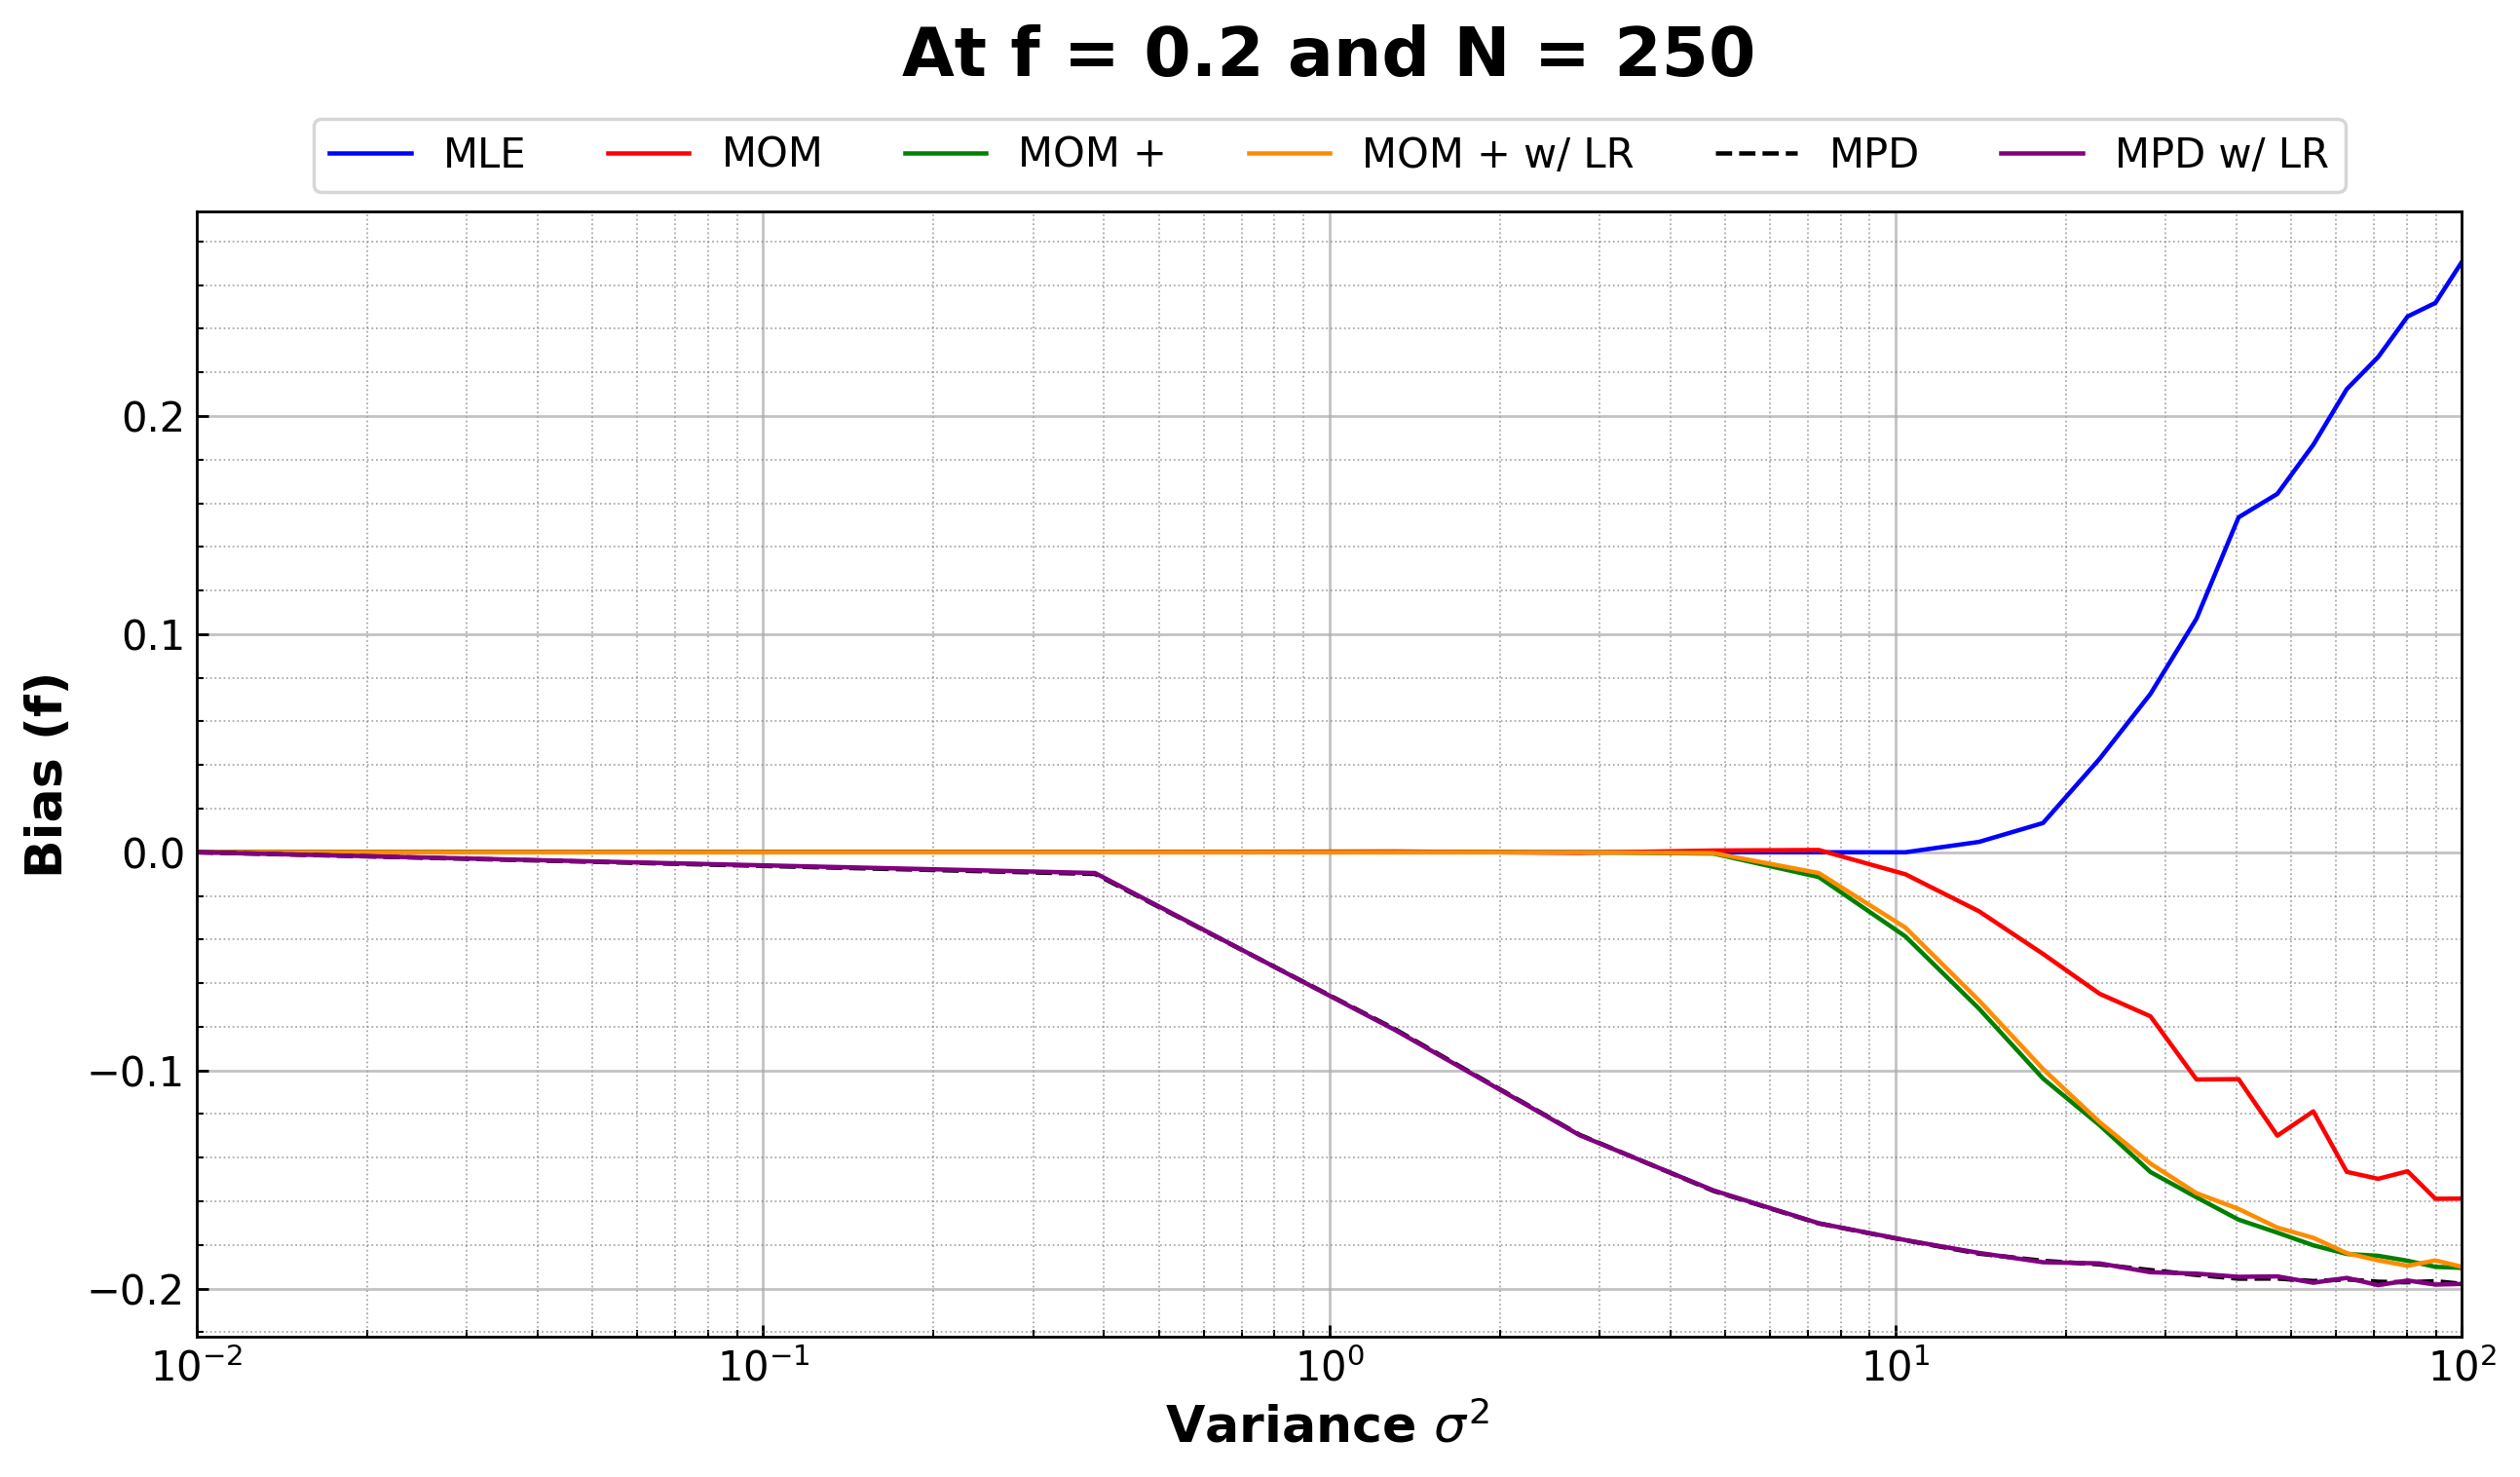

In [12]:
############### Generate Bias vs sigma ###############

f = 0.2
N = 250
S2 = np.linspace(0.1,10,20)

CRLB_list = []
MSE_list = []

TPD_list = []
TPD_Lin_list = [] 

MOM_list = [] 
MOM_Plus_list = []
MOM_Plus_Lin_list = [] 


start_time = datetime.now()
for s2 in S2:
    CRLB = get_CRLB_f_N(s2, N)
    CRLB_list.append(CRLB)
    MSE_list.append(get_MSE_N(s2, CRLB,N,f)[1])
    
    TPD_list.append(TPD_N(s2,  N, f)[1])
    TPD_Lin_list.append(TPD_N_Lin(s2, N, f)[1])

    MOM_list.append(get_MOM_N(s2, N, f)[1])
    MOM_Plus_list.append(get_MOM_plus_N(s2, N,  f)[1])
    MOM_Plus_Lin_list.append(get_MOM_plus_N_Lin(s2, N, f)[1])
    
end_time = datetime.now()
duration = end_time - start_time
print("Process Duration:", duration)

plt.figure(figsize=(12,6))
plt.plot(S2**2, MSE_list, label="MLE")
plt.plot(S2**2, MOM_list, label="MOM")
plt.plot(S2**2, MOM_Plus_list, label="MOM +")
plt.plot(S2**2, MOM_Plus_Lin_list, label="MOM + w/ LR")
plt.plot(S2**2, TPD_list, '--', label="MPD")
plt.plot(S2**2, TPD_Lin_list, color='purple', label="MPD w/ LR")

# plt.yscale("log")
plt.xscale("log")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.gca().tick_params(axis='x', pad=10)
plt.grid(True, which='major', linestyle='-', linewidth=0.8, color='darkgray')
plt.grid(True, axis='both', which='minor', linestyle=':', linewidth=0.5, color='gray')
plt.minorticks_on()
plt.ylabel("Bias (f)", fontsize = 15, fontweight = 'bold')
plt.xlabel("Variance $\sigma^2$ ", fontsize = 15, fontweight = 'bold')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fontsize = 12)
plt.xlim(np.min(S2**2), np.max(S2**2))
# plt.xlim(4, np.max(S2))

plt.title(f"At f = {f} and N = {N}", pad= 40, fontsize = 20, fontweight = 'bold')
# plt.savefig(f'Bias at f={f}, N={N}.pdf', dpi=400, bbox_inches='tight')

Process Duration: 0:01:45.764922


Text(0.5, 1.0, 'At f = 0.2 and N = 500')

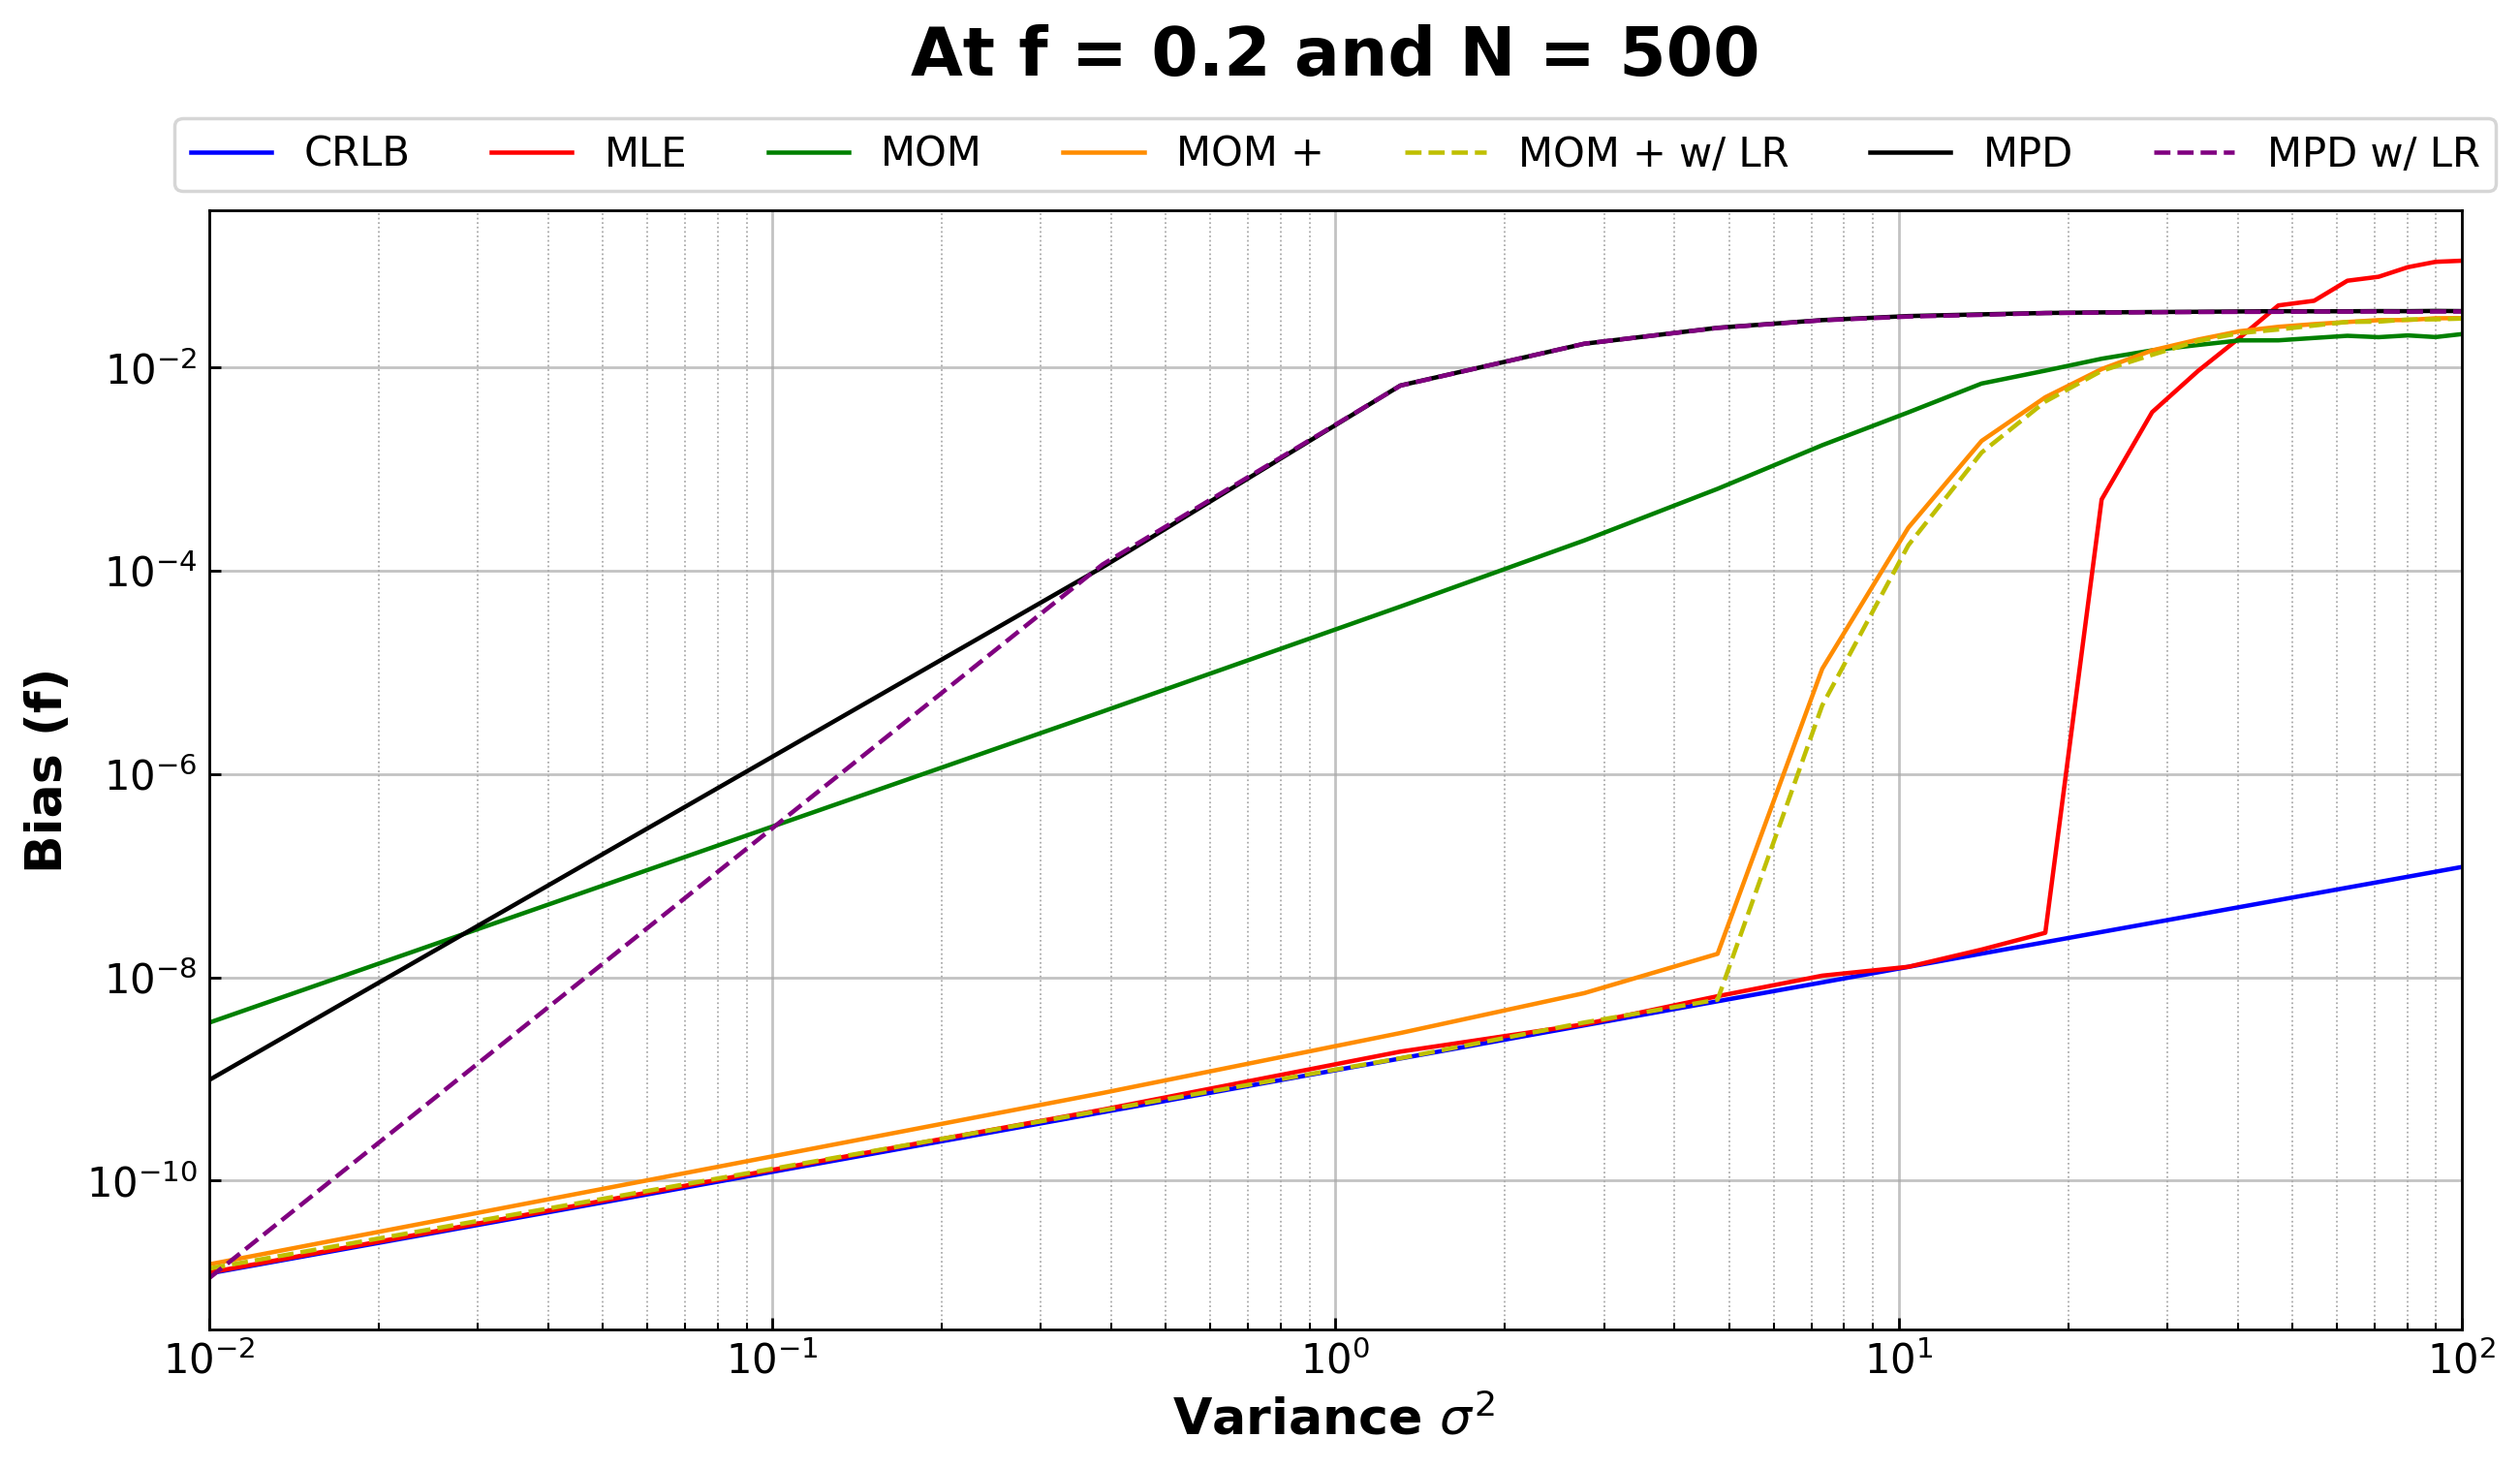

In [13]:
############### Generate MSE vs sigma ###############

f = 0.2
N = 500
S2 = np.linspace(0.1,10,20)

CRLB_list = []
MSE_list = []

TPD_list = []
TPD_Lin_list = [] 

MOM_list = [] 
MOM_Plus_list = []
MOM_Plus_Lin_list = [] 


start_time = datetime.now()
for s2 in S2:
    CRLB = get_CRLB_f_N(s2, N)
    CRLB_list.append(CRLB)
    MSE_list.append(get_MSE_N(s2, CRLB, N, f)[0])
    TPD_list.append(TPD_N(s2,  N, f)[0])
    TPD_Lin_list.append(TPD_N_Lin(s2, N, f)[0])
    MOM_list.append(get_MOM_N(s2, N, f)[0])
    
    MOM_Plus_list.append(get_MOM_plus_N(s2, N,  f)[0])
    MOM_Plus_Lin_list.append(get_MOM_plus_N_Lin(s2, N, f)[0])
    
end_time = datetime.now()
duration = end_time - start_time
print("Process Duration:", duration)

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#0000FF', 'r', 'g', 'darkorange', 'y', 'k'])
plt.figure(figsize=(12,6))
plt.plot(S2**2, CRLB_list, label="CRLB")
plt.plot(S2**2, MSE_list, label="MLE")

plt.plot(S2**2, MOM_list, label="MOM")
plt.plot(S2**2, MOM_Plus_list, label="MOM +")
plt.plot(S2**2, MOM_Plus_Lin_list, '--', label="MOM + w/ LR")

plt.plot(S2**2, TPD_list, label="MPD")
plt.plot(S2**2, TPD_Lin_list, '--', color='purple',  label="MPD w/ LR")

plt.yscale("log")
plt.xscale("log")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.gca().tick_params(axis='x', pad=10)
plt.grid(True, which='major', linestyle='-', linewidth=0.8, color='darkgray')
plt.grid(True, axis='both', which='minor', linestyle=':', linewidth=0.5, color='gray')
plt.minorticks_on()
plt.ylabel("MSE", fontsize = 15, fontweight = 'bold')
plt.xlabel("Variance $\sigma^2$ ", fontsize = 15, fontweight = 'bold')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=7, fontsize = 12)
plt.xlim(np.min(S2**2), np.max(S2**2))
# plt.xlim(4, np.max(S2))

plt.title(f"At f = {f} and N = {N}", pad= 40, fontsize = 20, fontweight = 'bold')
# plt.savefig(f'Project_f={f}.pdf', dpi=400, bbox_inches='tight')

Text(0.5, 1.0, 'at N = 100, $\\sigma^2$ = 0.25')

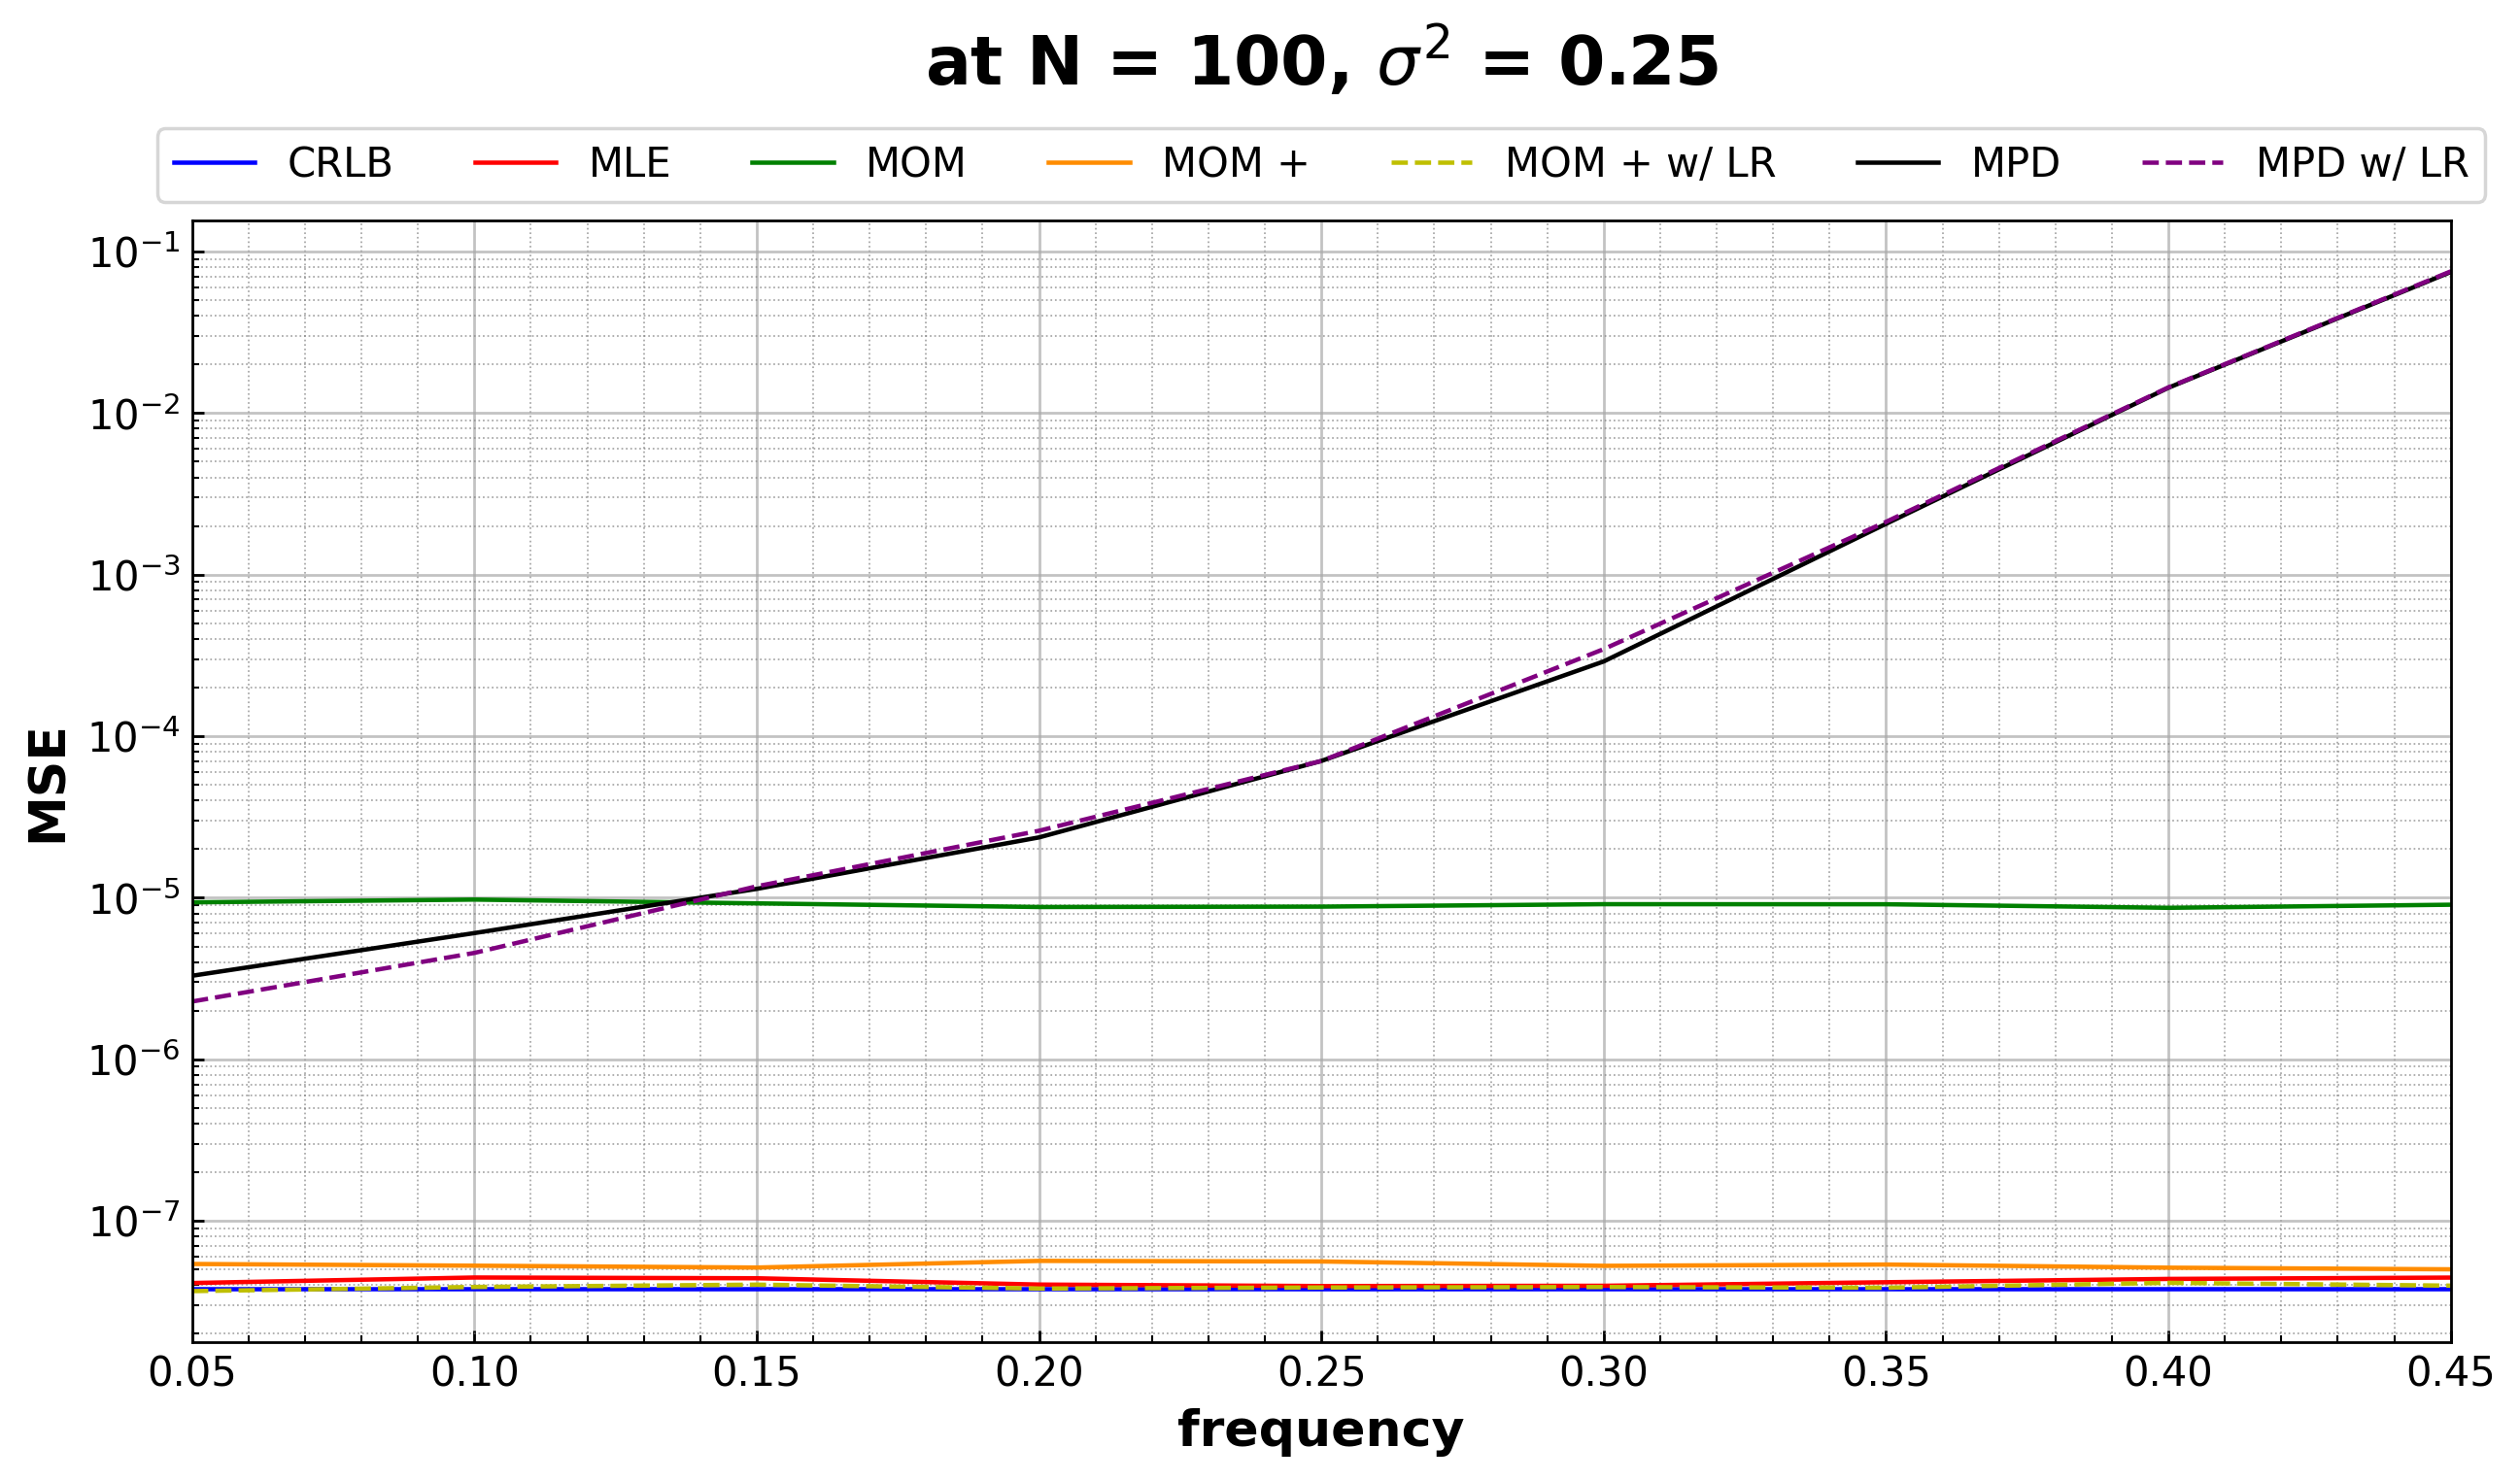

In [24]:
############### Generate MSE vs frequency ###############

fs = np.arange(0.05,0.49,0.05)
N = 100
s2 = 0.5

CRLB_list = []
MSE_list = []

TPD_list = []
TPD_Lin_list = [] 

MOM_list = [] 
MOM_Plus_list = []
MOM_Plus_Lin_list = [] 


start_time = datetime.now()
for f in fs:
    CRLB = get_CRLB_f_N(s2, N)
    CRLB_list.append(CRLB)
    MSE_list.append(get_MSE_N(s2, CRLB, N, f)[0])
    TPD_list.append(TPD_N(s2,  N, f)[0])
    TPD_Lin_list.append(TPD_N_Lin(s2, N, f)[0])
    MOM_list.append(get_MOM_N(s2, N, f)[0])
    
    MOM_Plus_list.append(get_MOM_plus_N(s2, N,  f)[0])
    MOM_Plus_Lin_list.append(get_MOM_plus_N_Lin(s2, N, f)[0])
    
end_time = datetime.now()
duration = end_time - start_time
print("Process Duration:", duration)

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#0000FF', 'r', 'g', 'darkorange', 'y', 'k'])
plt.figure(figsize=(12,6))
plt.plot(fs, CRLB_list, label="CRLB")
plt.plot(fs, MSE_list, label="MLE")

plt.plot(fs, MOM_list, label="MOM")
plt.plot(fs, MOM_Plus_list, label="MOM +")
plt.plot(fs, MOM_Plus_Lin_list, '--', label="MOM + w/ LR")

plt.plot(fs, TPD_list, label="MPD")
plt.plot(fs, TPD_Lin_list, '--', color='purple',  label="MPD w/ LR")

plt.yscale("log")
# plt.xscale("log")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.gca().tick_params(axis='x', pad=10)
plt.grid(True, which='major', linestyle='-', linewidth=0.8, color='darkgray')
plt.grid(True, axis='both', which='minor', linestyle=':', linewidth=0.5, color='gray')
plt.minorticks_on()
plt.ylabel("MSE", fontsize = 15, fontweight = 'bold')
plt.xlabel("frequency", fontsize = 15, fontweight = 'bold')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=7, fontsize = 12)
plt.xlim(np.min(fs), np.max(fs))

plt.title(f"at N = {N}, $\sigma^2$ = {s2**2}", pad= 40, fontsize = 20, fontweight = 'bold')
# plt.savefig(f'Project_f={f}.pdf', dpi=400, bbox_inches='tight')

Process Duration: 0:03:02.937400


Text(0.5, 1.0, 'at f = 0.2, $\\sigma^2$ = 0.25')

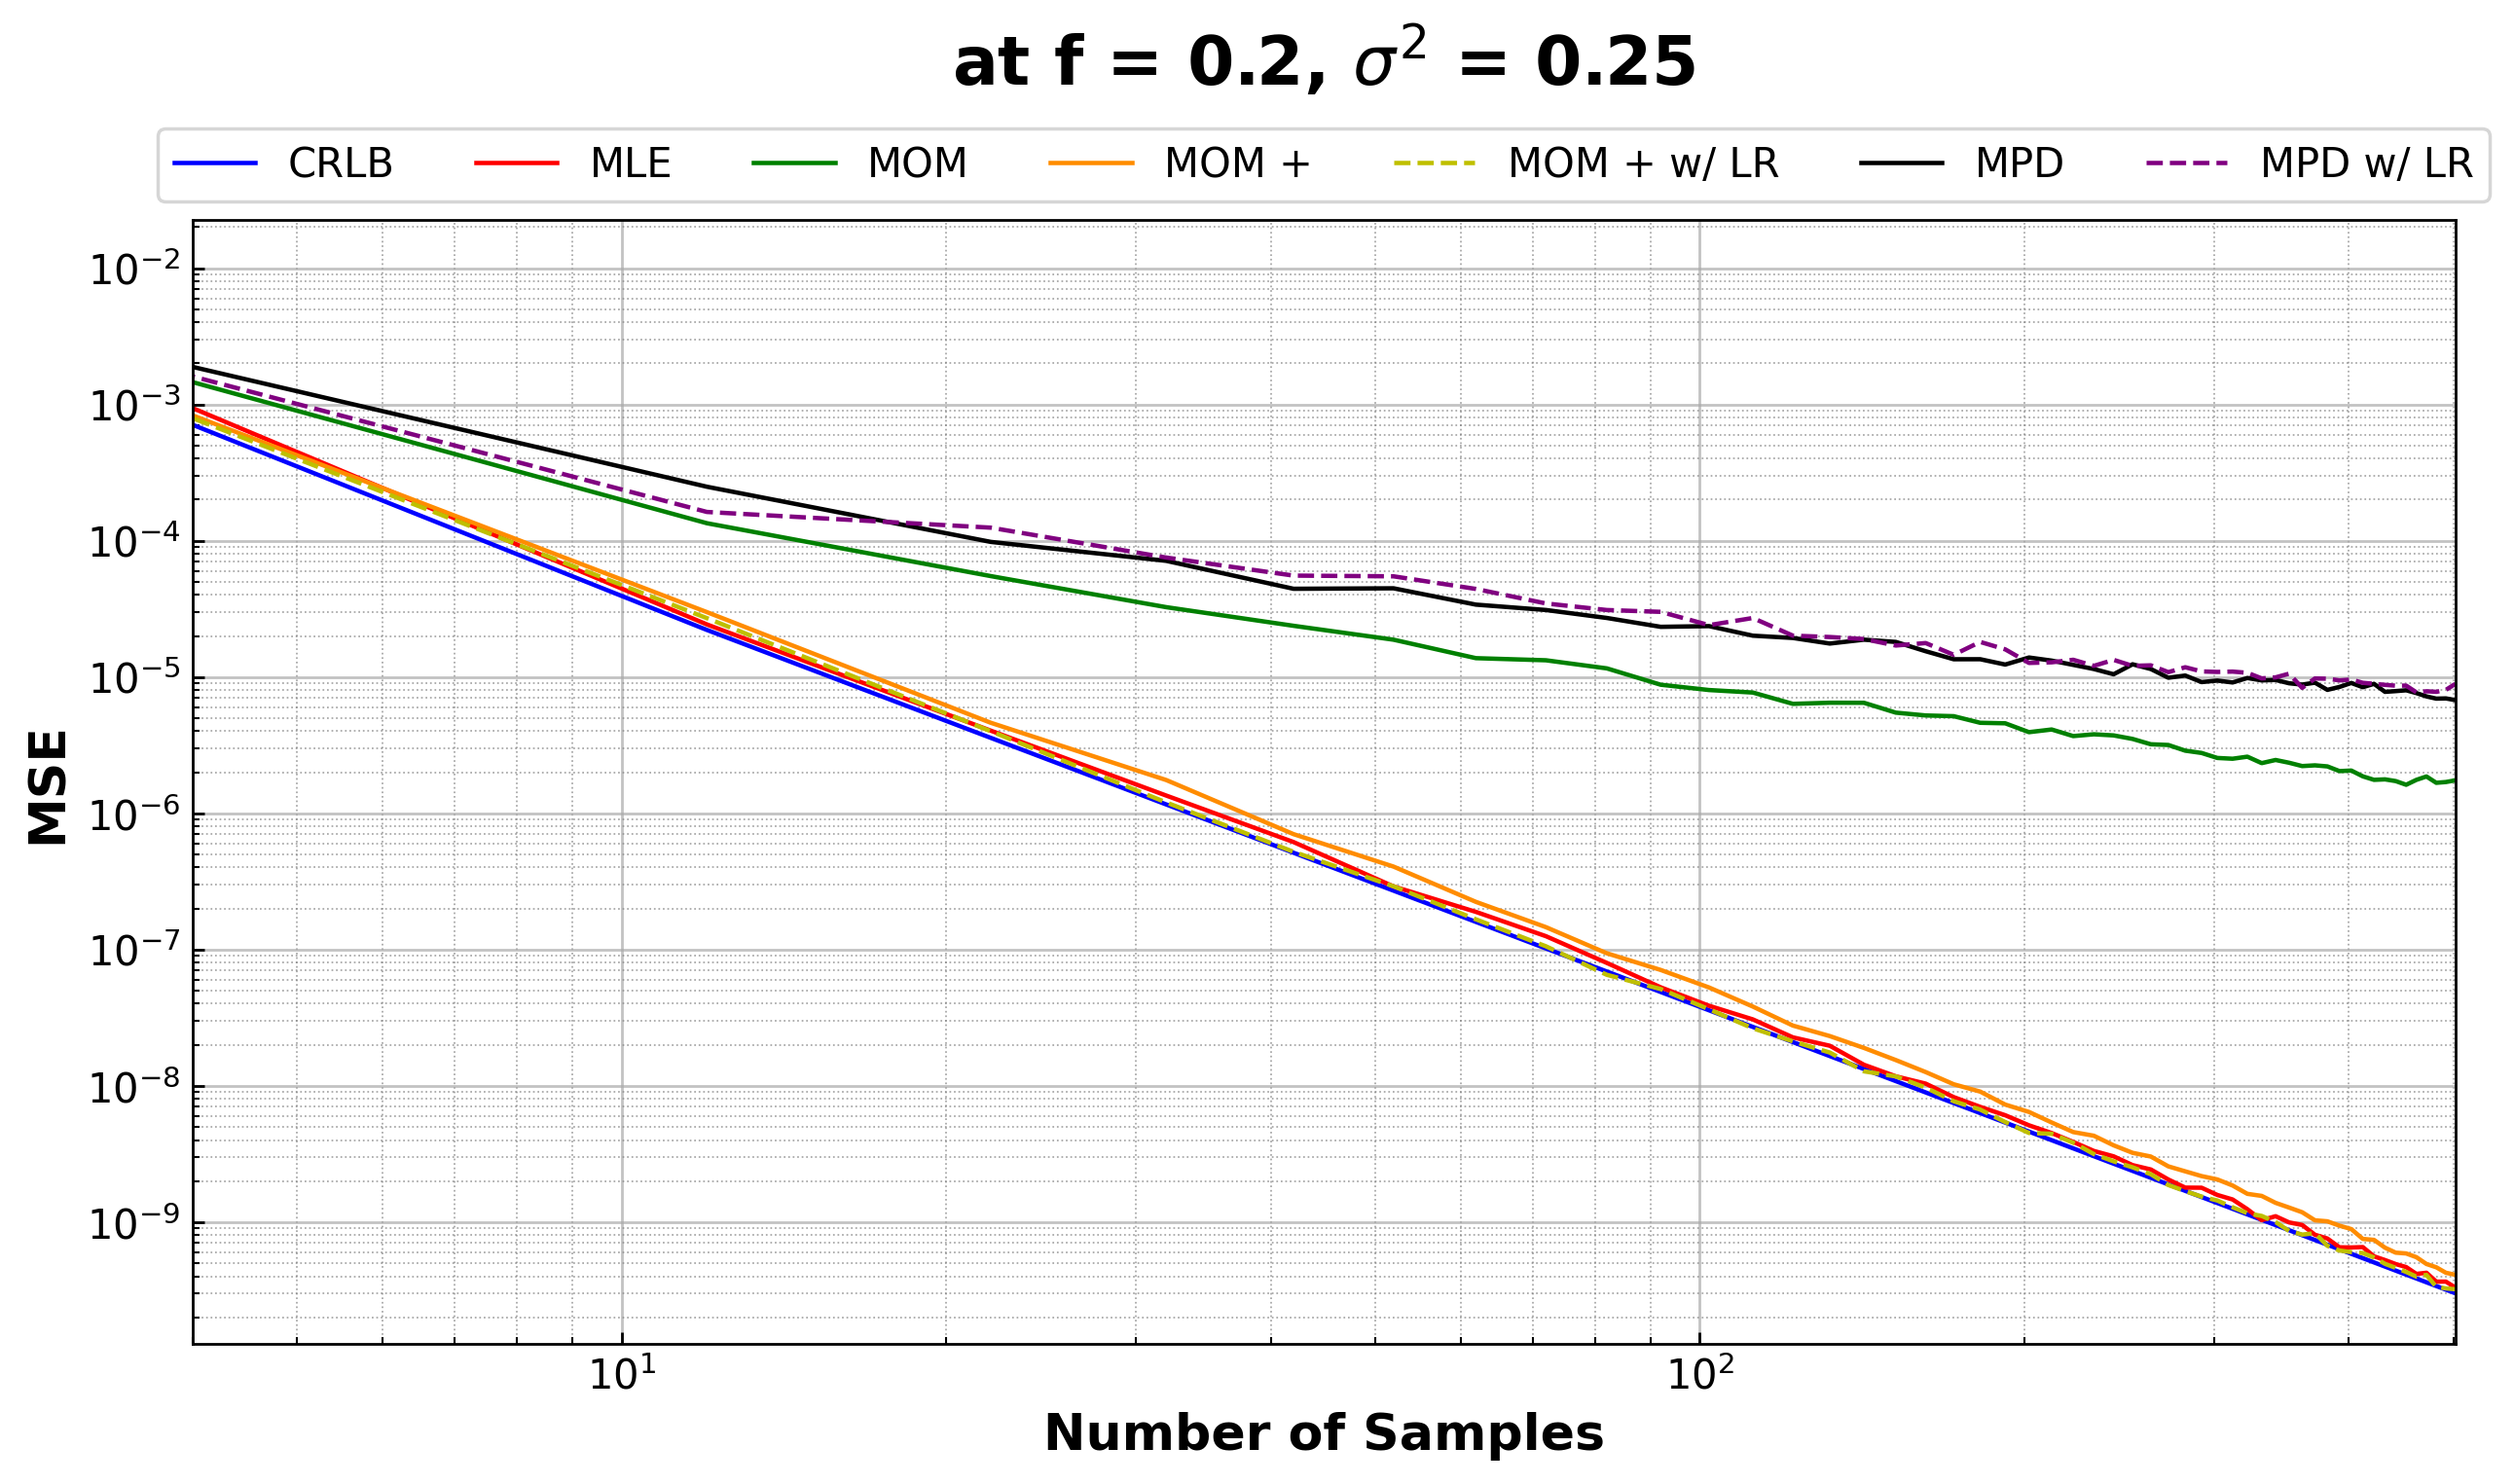

In [26]:
############### Generate MSE vs N ###############

f = 0.2
Ns = np.arange(2,510,10)
s2 = 0.5

CRLB_list = []
MSE_list = []

TPD_list = []
TPD_Lin_list = [] 

MOM_list = [] 
MOM_Plus_list = []
MOM_Plus_Lin_list = [] 


start_time = datetime.now()
for N in Ns:
    CRLB = get_CRLB_f_N(s2, N)
    CRLB_list.append(CRLB)
    MSE_list.append(get_MSE_N(s2, CRLB, N, f)[0])
    TPD_list.append(TPD_N(s2,  N, f)[0])
    TPD_Lin_list.append(TPD_N_Lin(s2, N, f)[0])
    MOM_list.append(get_MOM_N(s2, N, f)[0])
    
    MOM_Plus_list.append(get_MOM_plus_N(s2, N,  f)[0])
    MOM_Plus_Lin_list.append(get_MOM_plus_N_Lin(s2, N, f)[0])
    
end_time = datetime.now()
duration = end_time - start_time
print("Process Duration:", duration)

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#0000FF', 'r', 'g', 'darkorange', 'y', 'k'])
plt.figure(figsize=(12,6))
plt.plot(Ns, CRLB_list, label="CRLB")
plt.plot(Ns, MSE_list, label="MLE")

plt.plot(Ns, MOM_list, label="MOM")
plt.plot(Ns, MOM_Plus_list, label="MOM +")
plt.plot(Ns, MOM_Plus_Lin_list, '--', label="MOM + w/ LR")

plt.plot(Ns, TPD_list, label="MPD")
plt.plot(Ns, TPD_Lin_list, '--', color='purple',  label="MPD w/ LR")

plt.yscale("log")
plt.xscale("log")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.gca().tick_params(axis='x', pad=10)
plt.grid(True, which='major', linestyle='-', linewidth=0.8, color='darkgray')
plt.grid(True, axis='both', which='minor', linestyle=':', linewidth=0.5, color='gray')
plt.minorticks_on()
plt.ylabel("MSE", fontsize = 15, fontweight = 'bold')
plt.xlabel("Number of Samples", fontsize = 15, fontweight = 'bold')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=7, fontsize = 12)
plt.xlim(np.min(Ns), np.max(Ns))
plt.xlim(4, np.max(Ns))

plt.title(f"at f = {f}, $\sigma^2$ = {s2**2}", pad= 40, fontsize = 20, fontweight = 'bold')
# plt.savefig(f'Project_f={f}.pdf', dpi=400, bbox_inches='tight')

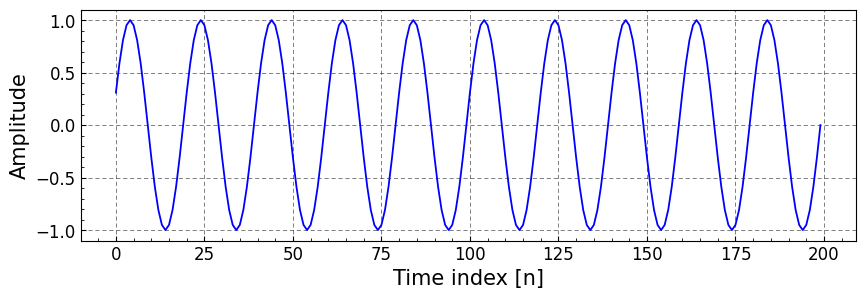

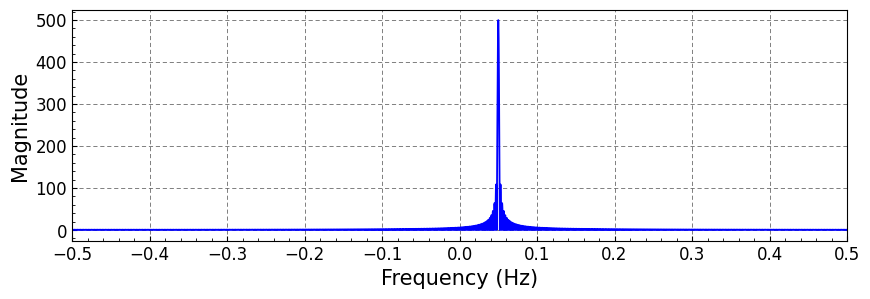

0.04999919473031518
Process Duration: 0:00:00.521289


In [30]:
############################## FFT Plotting ##############################

start_time = datetime.now()
plt.figure(figsize=(10,3), dpi=100)

N = 500
F = 0.1
s2 = 0
# CRLB = get_CRLB_f(s2)

pins= int(3/np.sqrt(12*CRLB))
noise = np.random.normal(0, s2/np.sqrt(2), N) + 1j * np.random.normal(0, s2/np.sqrt(2), N)
n = np.arange(1,N+1)
yt = np.exp(1j * 2*np.pi * (0.5*F) * n) + noise
# yt = np.exp(1j * 2*np.pi * (0.5*F) * n) +  0.3*np.exp(1j * 2*np.pi * (F) * n) +  0.5*np.exp(1j * 2*np.pi * (2*F) * n) +  np.exp(1j * 2*np.pi * (4*F) * n)+ noise
# yt *= np.exp(1j* 2*np.pi* np.random.normal(0,0.001, N) *n)
# yt = get_y(0.00,0, f1=F)  
plt.plot(np.imag(yt)[:200])
plt.ylabel("Amplitude")
plt.xlabel("Time index [n]")

plt.show()
plt.figure(figsize=(10,3), dpi=100)
plt.plot((np.arange(1,pins+1) - (pins/2))/ pins, (np.abs(np.fft.fftshift(np.fft.fft(yt, pins)))))
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")
plt.xticks(np.arange(-0.5,0.55, 0.1))
plt.xlim(-0.5, 0.5)
# plt.grid()
plt.show()
# plt.plot(np.imag(yt))

print(np.argmax(np.abs(np.fft.fft(yt, pins)))/pins)
end_time = datetime.now()
duration = end_time - start_time
print("Process Duration:", duration)

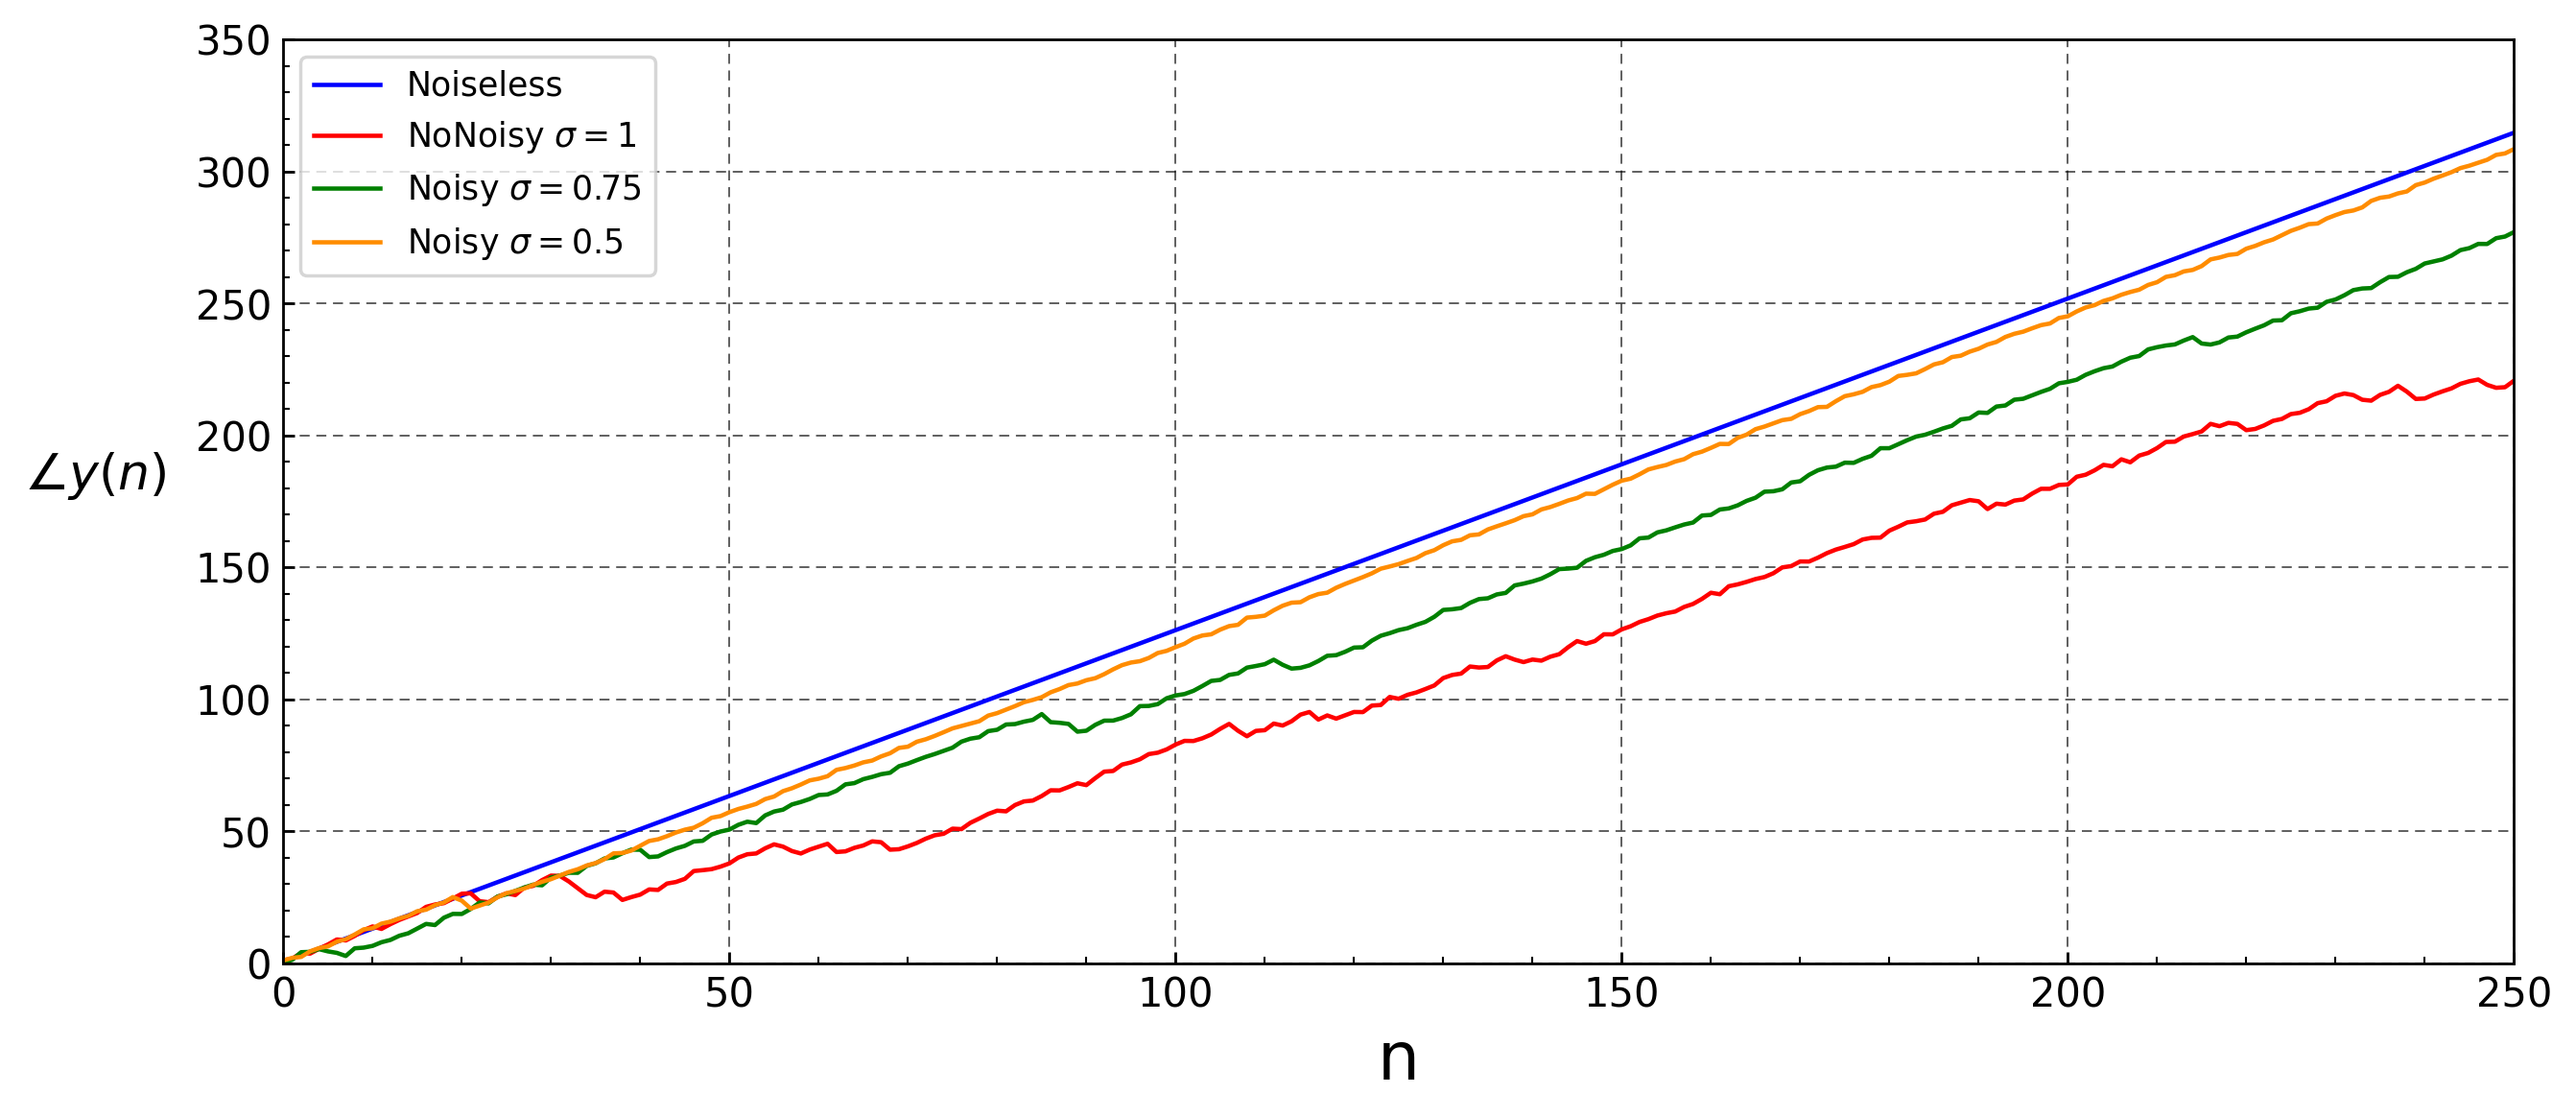

In [27]:
############################## MPD slope Plotting ##############################

y = get_y(0, 0.2)
# Ryy = np.correlate(y,y,"same")
plt.plot((np.unwrap(np.angle(y))), label="Noiseless")

y = get_y(1, 0.2)
# Ryy = np.correlate(y,y,"same")
plt.plot((np.unwrap(np.angle(y))), label="NoNoisy $\sigma=1$")

y = get_y(0.75, 0.2)
# Ryy = np.correlate(y,y,"same")
plt.plot((np.unwrap(np.angle(y))), label="Noisy $\sigma=0.75$")

y = get_y(0.5, 0.2)
# Ryy = np.correlate(y,y,"same")
plt.plot((np.unwrap(np.angle(y))), label="Noisy $\sigma=0.5$")

plt.ylabel(r"$\angle y(n)$", rotation=0, labelpad=30, fontsize=15)
plt.xlabel("n", fontsize=20)
plt.xlim(0,250)
plt.ylim(0,350)
plt.legend()

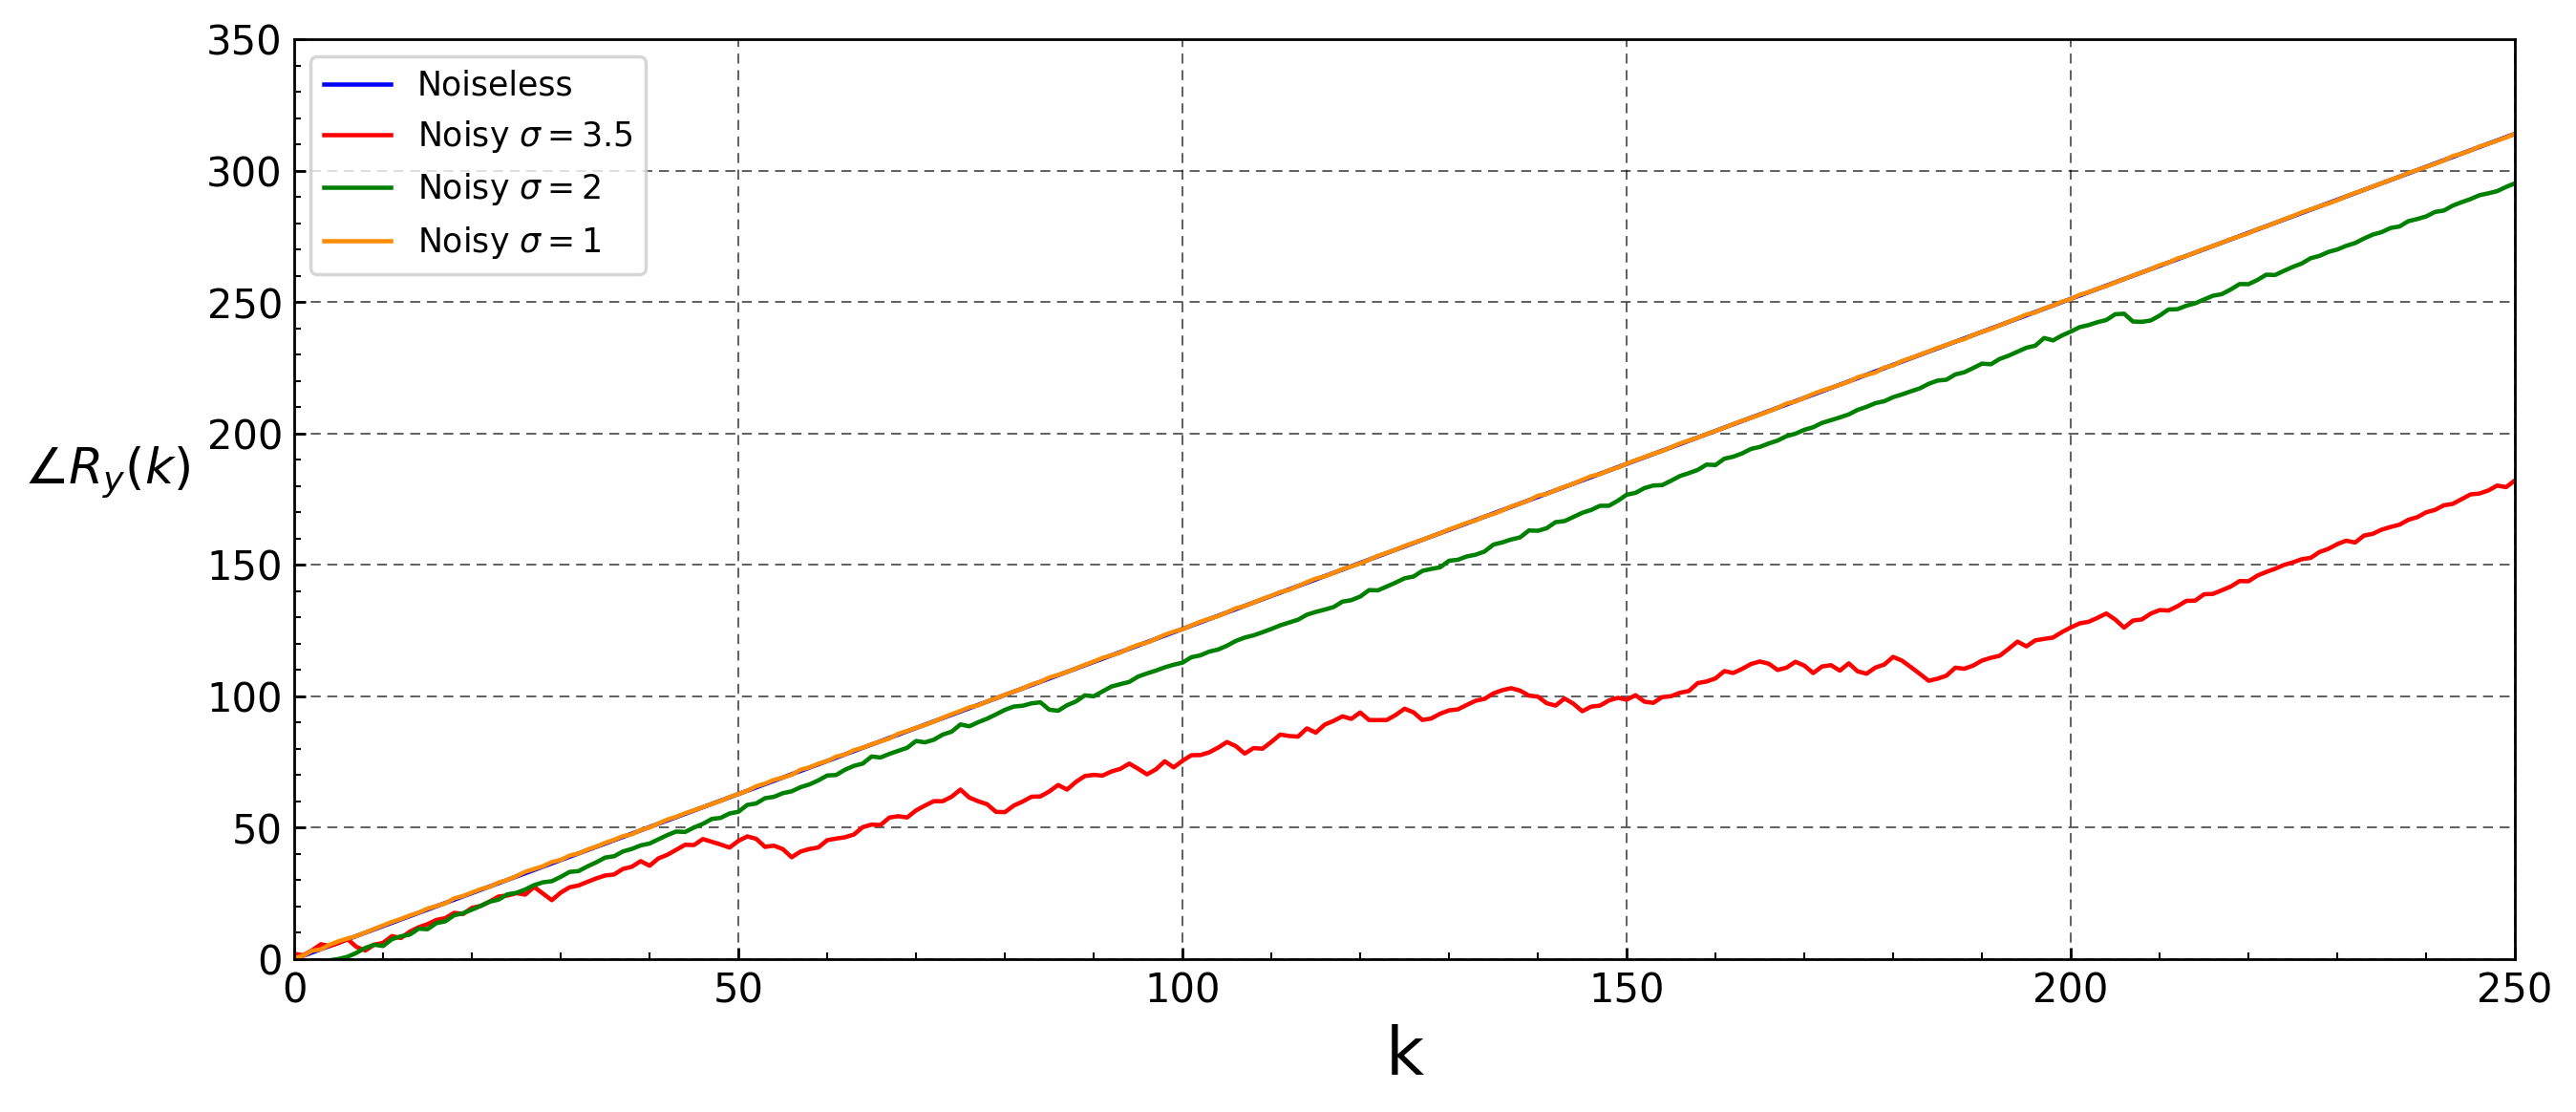

In [28]:
############################## MOM+ slope Plotting ##############################

y = get_y(0, 0.2)
Ryy = np.correlate(y,y,"same")
plt.plot(np.unwrap(np.angle(Ryy)), label="Noiseless")

y = get_y(3.5, 0.2)
Ryy = np.correlate(y,y,"same")
plt.plot(np.unwrap(np.angle(Ryy)), label="Noisy $\sigma=3.5$")

y = get_y(3, 0.2)
Ryy = np.correlate(y,y,"same")
plt.plot(np.unwrap(np.angle(Ryy)), label="Noisy $\sigma=2$")

y = get_y(2, 0.2)
Ryy = np.correlate(y,y,"same")
plt.plot(np.unwrap(np.angle(Ryy)), label="Noisy $\sigma=1$")

plt.ylabel(r"$\angle R_{y}(k)$", rotation=0, labelpad=30, fontsize=15)
plt.xlabel("k", fontsize=20)
plt.xlim(0,250)
plt.ylim(0,350)
plt.legend()